In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

from utilities import *

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


PyTorch Version: 1.8.1
Torchvision Version: 0.2.2
GPU is available? True


In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST

In [3]:
# we download and normalize the datasets

ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

# Train - test split

Code taken from https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb

In [4]:
x_train, y_train, x_test, y_test = train_test_split(mnist_trainset, mnist_testset)

# we move to device to use GPU

x_train = x_train.to(device = device)
x_test = x_test.to(device = device)
y_train = y_train.to(device = device)
y_test = y_test.to(device = device)

In [5]:
batch_size = 1000

# we import the dataloaders

dataset_test = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True, transform=torchvision.transforms.ToTensor()), 
  batch_size=100,
  shuffle=True
)
dataset_train = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
  batch_size=batch_size,
  shuffle=True
)

# Base architecture

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [6]:
input_size = 28*28
hidden_size = 1500
output_size = 10

In [7]:
# model architecture definition

class MultiLayerPerceptron(torch.nn.Module):
    
    # fully connected neural network with 2 hidden layers with 1500 neurons each. We use ReLU activation functions
    
    def __init__(self):
        super(MultiLayerPerceptron,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.fc_in = nn.Linear(self.input_size,self.hidden_size,bias=True) # fully connected input_layer
        self.fc_hid_1 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) # fully connected hidden_layer_1
        self.fc_hid_2 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) # fully connected hidden_layer_2
        self.fc_out = nn.Linear(self.hidden_size,self.output_size,bias=True)
    
    def forward(self,x):
        batch_size = x.shape[0]
        x = x.view(batch_size, self.input_size)
        x = self.relu(self.fc_in(x))
        x = self.relu(self.fc_hid_1(x))
        x = self.relu(self.fc_hid_2(x))
        x = self.fc_out(x)
        return x    

In [8]:
#initialize the model
mlp = MultiLayerPerceptron().to(device)

# Optimizers & Loss functions Definitions

1. SGD from pytorch 
2. CrossEntropyLoss function criterion

In [9]:
learning_rate = 0.001

optimizer_SGD = optim.SGD(mlp.parameters(), lr=learning_rate, momentum=0.9)

cross_entropy = nn.CrossEntropyLoss()

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

In [10]:
def train_model(model, dataset_train, dataset_test, optimizer, criterion, epochs):
    """
    The function is used to train the neural network
    :param model: <class '__main__.MultiLayerPerceptron'>
                    The model we wish to train
    :param dataset_train: <class 'torch.utils.data.dataloader.DataLoader'>
                    The train pytorch dataloader
    :param dataset_test: <class 'torch.utils.data.dataloader.DataLoader'>
                    The test pytorch dataloader
    :param optimizer: <class 'torch.optim.sgd.SGD'>
                    The used pytorch optimizer
    :param criterion: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
                    The loss used during the training
    :param epochs: int
                    The number of epochs
    :return: train losses, accuracies: lists of training losses and test accuracies respectively
    """
    train_losses = []
    accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_loss = 0.0
        model.train()
        running_loss = 0
        n_steps = 0
        for batch_x, batch_y in dataset_train:
            n_steps = n_steps + 1
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Get output and evaluate with loss function
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            running_loss += loss.item() * len(batch_y)

            # Initialize optimizer
            optimizer.zero_grad()
            loss.backward()

            # Update the network
            optimizer.step()

        running_loss = running_loss / n_steps
        train_losses.append(running_loss)

        # Test the quality on the test set
        model.eval()
        accuracies_test = []

        for batch_x, batch_y in dataset_test:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            accuracies_test.append(accuracy(prediction, batch_y))

        print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item() / len(accuracies_test)))

        accuracies.append(sum(accuracies_test).item() / len(accuracies_test))
    return train_losses, accuracies

In [11]:
num_epochs = 50

start = time.time()

#train using sgd
train_losses_SGD, accuracies_test_SGD = train_model(mlp, dataset_train, dataset_test, optimizer_SGD, cross_entropy, num_epochs)

end = time.time()
print('\n')
print('The total time spent is', end - start)

Epoch 0 | Test accuracy: 0.21110
Epoch 1 | Test accuracy: 0.37300
Epoch 2 | Test accuracy: 0.49930
Epoch 3 | Test accuracy: 0.58680
Epoch 4 | Test accuracy: 0.62060
Epoch 5 | Test accuracy: 0.64200
Epoch 6 | Test accuracy: 0.65140
Epoch 7 | Test accuracy: 0.66570
Epoch 8 | Test accuracy: 0.67980
Epoch 9 | Test accuracy: 0.69600
Epoch 10 | Test accuracy: 0.71730
Epoch 11 | Test accuracy: 0.72880
Epoch 12 | Test accuracy: 0.74960
Epoch 13 | Test accuracy: 0.77370
Epoch 14 | Test accuracy: 0.78860
Epoch 15 | Test accuracy: 0.80070
Epoch 16 | Test accuracy: 0.81410
Epoch 17 | Test accuracy: 0.82600
Epoch 18 | Test accuracy: 0.83340
Epoch 19 | Test accuracy: 0.84200
Epoch 20 | Test accuracy: 0.85070
Epoch 21 | Test accuracy: 0.85740
Epoch 22 | Test accuracy: 0.86180
Epoch 23 | Test accuracy: 0.86730
Epoch 24 | Test accuracy: 0.87290
Epoch 25 | Test accuracy: 0.87730
Epoch 26 | Test accuracy: 0.88070
Epoch 27 | Test accuracy: 0.88310
Epoch 28 | Test accuracy: 0.88640
Epoch 29 | Test accuracy

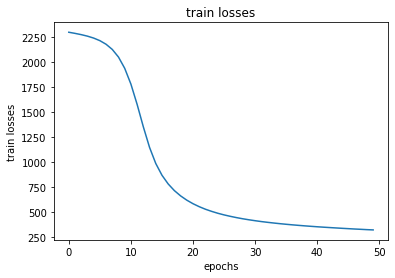

In [12]:
## We plot the train losses

plot_train_losses(num_epochs, train_losses_SGD, 'SGD')

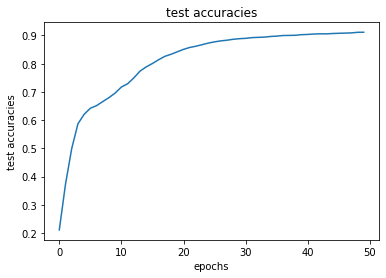

In [13]:
## We plot the test accuracy

plot_test_accuracy(num_epochs, accuracies_test_SGD, 'SGD')